In [1]:
import seaborn as sns
import pandas as pd

In [4]:
iteration_convergence_dict = dict()

In [19]:
import numpy as np
import json
import string
import operator
from collections import *

class OrderedCounter(Counter, OrderedDict):
    pass

"""
 Brainstormed features:
 - sentiment analysis
"""

def get_features(top_words, data):
    num_data_points = len(data)
    num_features = len(top_words) + 4

    x_train = np.zeros((num_data_points, num_features))
    y_train = np.zeros(num_data_points)
    i = 0
    for data_point in data:
        features = np.zeros(num_features)
        word_list = process_string(data_point['text'])
    
        for word in word_list:
            if word in top_words:
                index = top_words.index(word)
                features[index] += 1

        features[num_features - 4] = data_point["controversiality"]
        features[num_features - 3] = data_point["children"]
        features[num_features - 2] = 1 if data_point["is_root"] else 0
        features[num_features - 1] = 1 # bias term

        x_train[i] = features
        y_train[i] = data_point["popularity_score"]
        i = i+1

    # TODO: at least two more features: these can be 
    # based on the text data, transformations of the other numeric features, or interaction terms. 
    return x_train, y_train

def calculate_closed_form(X, Y):
    coeffs = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(Y)
    return coeffs

def calculate_gradient_descent(X, y, init_weights, beta=10**-9, alpha=10**-6, epsilon=4*10**-5):
    error = 10
    new_weights = init_weights
    iteration = 0
    iteration_convergence_dict = dict()

    while error > epsilon:
        weights = new_weights

        # the error was here, Prof mentioned in class that the learning rate
        # should be scaled by 1/n where n = # training points
        gradient = X.T.dot(X.dot(weights) - y)
        new_weights = weights - 2* alpha/(1+beta) * gradient
        error = np.linalg.norm((new_weights - weights),2)
        iteration +=1
        iteration_convergence_dict[iteration] = error
    
    return new_weights, iteration_convergence_dict

def read_json_file():
    file = open('./data/proj1_data.json', 'r')
    data= file.read()
    file.close()
    json_data = json.loads(data)
    return json_data

def process_string(str):
    return str.lower().split(' ')

def count_top_words(data, num_top_words):
    word_freq = OrderedCounter()
    for line in data:
        word_list = process_string(line['text'])
        word_freq.update(word_list)
    most_common = dict(word_freq.most_common(num_top_words))
    return list(most_common.keys())

def split_data(data, first_split, second_split, third_split):
    train, validation, test = [], [], []

    for i in range(0, first_split):
        train.append(data[i])

    for i in range(first_split, second_split):
        validation.append(data[i])

    for i in range(second_split, third_split):
        test.append(data[i]) 

    return train, validation, test

def calculate_mean_squared_error(predicted_scores, actual_scores):
    total_error = 0
    for x, y in np.nditer([predicted_scores, actual_scores]):
        squared_difference = (x - y)**2 
        total_error += squared_difference
    mean_squared_error = total_error / len(predicted_scores)
    return mean_squared_error

def evaluate_model(top_words, weights, dataset):
    x_validate, y_validate = get_features(top_words, dataset)
    predicted_scores_validate = x_validate.dot(weights)
    actual_scores_validate = y_validate
    error = calculate_mean_squared_error(predicted_scores_validate, actual_scores_validate)
    return error 

def main():
    data = read_json_file()

    """
    Use the first 10,000 points for training, the next 1,000 for validation, and the final 1,000 for testing.
    """
    train, validation, test = split_data(data, 10000, 11000, 12000)

    top_words = count_top_words(train, 160) # top 160 words
    
    x_train, y_train = get_features(top_words, train)

    """
    Calculate closed form and gradient descent weights.
    """
    closed_form_weights = calculate_closed_form(x_train, y_train)
    closed_form_error = evaluate_model(top_words, closed_form_weights, train)
    print("Mean squared error is " + str(closed_form_error) + " for closed form weights on the training set.")

    weights = np.zeros(164)
    gradient_descent_weights, iteration_convergence_dict = calculate_gradient_descent(x_train, y_train, weights, beta=0.1)
    gradient_descent_error = evaluate_model(top_words, gradient_descent_weights, train)
    print("Mean squared error is " + str(gradient_descent_error) + " for gradient descent weights on the training set.")
 
    # print out weights, include in report
    """
    Evaluate closed form and gradient descent weights.
    """
    closed_form_error = evaluate_model(top_words, closed_form_weights, validation)
    print("Mean squared error is " + str(closed_form_error) + " for closed form weights on the validation set.")

    gradient_descent_error = evaluate_model(top_words, gradient_descent_weights, validation)
    print("Mean squared error is " + str(gradient_descent_error) + " for gradient descent weights on the validation set.")

    """
    Create and evaluate models with no text features, top 60 words, and top 160 words
    """
    # no text features
    no_text_x_train, no_text_y_train = get_features([], train)
    no_text_closed_form_weights, iteration_convergence_dict_0 = calculate_gradient_descent(no_text_x_train, no_text_y_train, init_weights=np.zeros(4), beta=0.1)
    no_text_training_error = evaluate_model([], no_text_closed_form_weights, train)
    no_text_validation_error = evaluate_model([], no_text_closed_form_weights, validation)
    print("MSE is " + str(no_text_training_error) + " for no-text features model on the training set. (closed form)" )
    print("MSE is " + str(no_text_validation_error) + " for no-text features model on the validation set. (closed form)" )

    # top 60 words
    top_words = count_top_words(train, 60)
    top60_x_train, top60_y_train = get_features(top_words, train)
    top60_closed_form_weights, iteration_convergence_dict_60  = calculate_gradient_descent(top60_x_train, top60_y_train, init_weights=np.zeros(64), beta=0.1)
    
#     top60_training_error = evaluate_model(top_words, top60_closed_form_weights, train)
#     top60_validation_error = evaluate_model(top_words, top60_closed_form_weights, validation)
#     print("MSE is " + str(top60_training_error) + " for 60-word features model on the training set. (closed form)" )
#     print("MSE is " + str(top60_validation_error) + " for 60-word features model on the validation set. (closed form)" )

    # top 160 words
    top_words = count_top_words(train, 160)
    top160_x_train, top160_y_train = get_features(top_words, train)
#     top160_closed_form_weights = calculate_closed_form(top160_x_train, top160_y_train, weights, beta=0.1)
#     top160_training_error = evaluate_model(top_words, top160_closed_form_weights, train)
#     top160_validation_error = evaluate_model(top_words, top160_closed_form_weights, validation)
#     print("MSE is " + str(top160_training_error) + " for 160-word features model on the training set. (closed form)" )
#     print("MSE is " + str(top160_validation_error) + " for 160-word features model on the validation set. (closed form)" )


    return iteration_convergence_dict, iteration_convergence_dict_0, iteration_convergence_dict_60


if __name__ == '__main__':
    iteration_convergence_dict, iteration_convergence_dict_0, iteration_convergence_dict_60 = main()

Mean squared error is 1.046832911778383 for closed form weights on the training set.
Mean squared error is 1.047460429101807 for gradient descent weights on the training set.
Mean squared error is 0.9895357003238052 for closed form weights on the validation set.
Mean squared error is 0.9905534926478462 for gradient descent weights on the validation set.
MSE is 1.0851022444567002 for no-text features model on the training set. (closed form)
MSE is 1.0214067892943572 for no-text features model on the validation set. (closed form)


In [6]:
iteration_convergence_dict

{1: 0.04081255242126072,
 2: 0.03223133207999401,
 3: 0.02648010310656065,
 4: 0.02268870934122919,
 5: 0.020194130089902475,
 6: 0.018516552034649032,
 7: 0.01733332274600616,
 8: 0.016442276704692976,
 9: 0.015723438225157687,
 10: 0.015108105319035283,
 11: 0.014557718794715634,
 12: 0.014050805201443212,
 13: 0.01357537227058642,
 14: 0.013124628083376198,
 15: 0.012694617333741798,
 16: 0.012282930210445044,
 17: 0.011888001356687317,
 18: 0.011508730400491957,
 19: 0.011144276806078395,
 20: 0.010793948943975708,
 21: 0.010457144002307255,
 22: 0.01013331530957772,
 23: 0.009821954432670187,
 24: 0.009522581240946126,
 25: 0.009234738269286148,
 26: 0.008957987405675574,
 27: 0.00869190784047389,
 28: 0.008436094705189422,
 29: 0.008190158092641786,
 30: 0.007953722292471871,
 31: 0.007726425152388016,
 32: 0.007507917516643077,
 33: 0.0072978627153461924,
 34: 0.0070959360900974735,
 35: 0.0069018245478259035,
 36: 0.006715226138147161,
 37: 0.006535849651402043,
 38: 0.00636341

Text(0.5,0,'Number of Iterations')

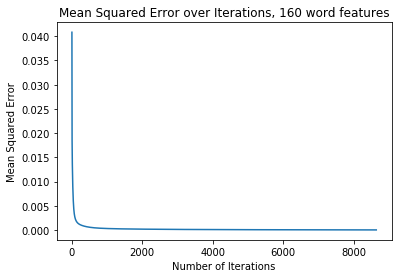

In [12]:
chart = sns.lineplot(x=iteration_convergence_dict.keys(), y=iteration_convergence_dict.values())
chart.set_title('Mean Squared Error over Iterations, 160 word features')
chart.set_ylabel('Mean Squared Error')
chart.set_xlabel('Number of Iterations')


Text(0.5,0,'Number of Iterations')

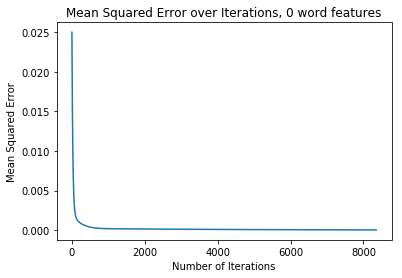

In [20]:
chart = sns.lineplot(x=iteration_convergence_dict_0.keys(), y=iteration_convergence_dict_0.values())
chart.set_title('Mean Squared Error over Iterations, 0 word features')
chart.set_ylabel('Mean Squared Error')
chart.set_xlabel('Number of Iterations')


Text(0.5,0,'Number of Iterations')

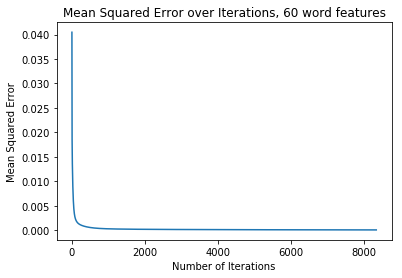

In [42]:
chart = sns.lineplot(x=iteration_convergence_dict_60.keys(), y=iteration_convergence_dict_60.values())
chart.set_title('Mean Squared Error over Iterations, 60 word features')
chart.set_ylabel('Mean Squared Error')
chart.set_xlabel('Number of Iterations')


In [36]:
all_values = {}
for key in iteration_convergence_dict_60.keys():
    all_values[key] = [iteration_convergence_dict_0[key], iteration_convergence_dict_60[key], iteration_convergence_dict[key]]
    

In [34]:
print("It took " + str(len(iteration_convergence_dict_0)) + " iterations to converge with 0 word features")

It took 8353 iterations to converge with 0 word features


In [35]:
print("It took " + str(len(iteration_convergence_dict_60)) + " iterations to converge with 60 word features")

It took 8347 iterations to converge with 60 word features


In [31]:
print("It took " + str(len(iteration_convergence_dict)) + " iterations to converge with 160 word features")

It took 8647 iterations to converge with 160 word features


TypeError: unhashable type: 'list'

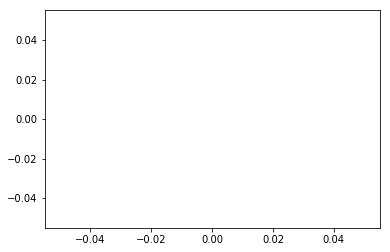

In [37]:
chart = sns.lineplot(x=all_values.keys(), y=all_values.values())
chart.set_title('Mean Squared Error over Iterations up to 8347 iterations')
chart.set_ylabel('Mean Squared Error')
chart.set_xlabel('Number of Iterations')

In [38]:
import matplotlib as plt

In [66]:
mse_vs_feature_set_160 = {
    "baseline": 0.9895, 
    "word_count,avg_wordlen,urls,extract_keywords,avg_keyword": 0.985558231296495,
    "word_count,avg_wordlen,urls": 0.9893830598686777,
    "extract_keywords,avg_keyword": 0.9864798298937568,
}

TypeError: bar() got multiple values for keyword argument 'align'

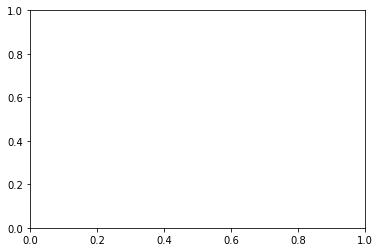

In [69]:
g = sns.barplot(x=mse_vs_feature_set_160.keys(), y=mse_vs_feature_set_160.values(), )
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set(ylim=(0.975, 1.0))
